In [1]:
import torch
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
train_features = torch.load('../data/processed/train_features.pt')
train_features = pd.DataFrame(train_features.numpy(),
                                 columns=["y", "x", "1y", "5y", "10y", "urban", "slope",
                                          "landuse", "soil", "current", "target"])

In [3]:
train_features[["1y", "5y", "10y", "urban", "slope"]] = np.log(train_features[["1y", "5y", "10y", "urban", "slope"]] + 10)

feature_names = ["y", "x", "1y", "5y", "10y", "urban", "slope"]
mean = np.mean(train_features[feature_names], axis=0)
std = np.std(train_features[feature_names], axis=0)
train_features[feature_names] = (train_features[feature_names] - mean) / std

train_features["target"] = train_features["target"].replace(2, 0)
train_features["target"] = train_features["target"].replace(4, 1)

X_train = train_features[feature_names]
y_train = train_features["target"]

In [4]:
train_features.describe()

,y,x,1y,5y,10y,urban,slope,landuse,soil,current,target
count,1.802120e+05,1.802120e+05,1.802120e+05,1.802120e+05,1.802120e+05,1.802120e+05,1.802120e+05,180212.000000,180212.000000,180212.0,180212.000000
mean,3.175598e-07,-2.135834e-07,-6.732217e-07,3.626896e-07,4.471493e-07,-7.843740e-08,-2.073812e-07,1.092097,0.024249,2.0,0.007452
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.320839,0.257747,0.0,0.086005
min,-2.547055e+00,-2.558088e+00,-2.081515e+00,-2.320465e+00,-1.977223e+00,-4.624981e+00,-2.553624e+00,1.000000,0.000000,2.0,0.000000
25%,-7.289603e-01,-6.616241e-01,-6.795231e-01,-7.625946e-01,-8.491957e-01,-5.021139e-01,-5.877283e-01,1.000000,0.000000,2.0,0.000000
50%,-5.252651e-03,8.916771e-02,-1.302547e-01,1.463073e-01,2.034902e-02,1.300894e-01,2.405622e-01,1.000000,0.000000,2.0,0.000000
75%,8.214216e-01,7.983931e-01,6.101880e-01,8.613849e-01,8.511077e-01,6.736014e-01,7.561670e-01,1.000000,0.000000,2.0,0.000000
max,2.377687e+00,2.037589e+00,4.560678e+00,1.485838e+00,1.745249e+00,3.172279e+00,2.949440e+00,5.000000,3.000000,2.0,1.000000


In [5]:
val_features = torch.load('../data/processed/val_features.pt')
val_features = pd.DataFrame(val_features.numpy(),
                                 columns=["y", "x", "1y", "5y", "10y", "urban", "slope",
                                          "landuse", "soil", "current", "target"])
val_features[["1y", "5y", "10y", "urban", "slope"]] = np.log(val_features[["1y", "5y", "10y", "urban", "slope"]] + 10)
val_features[feature_names] = (val_features[feature_names] - mean) / std

val_features["target"] = val_features["target"].replace(2, 0)
val_features["target"] = val_features["target"].replace(4, 1)

X_val = val_features[feature_names]
y_val = val_features["target"]

In [17]:
weight_target_class_arr = [0.5,0.6,0.7,0.8,0.9,0.99,0.999,0.9999,0.99999]

# hyperparameter tuning
for weight_target_class in weight_target_class_arr:
    class_weights = {0:1-weight_target_class,
                     1:weight_target_class}
    clf = RandomForestClassifier(class_weight=class_weights)
    clf.fit(X_train, y_train)

    probabilities = clf.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, probabilities)
    f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
    print("Weight target class: ", weight_target_class)
    print("F1: ", np.max(f1))


Weight target class:  0.5
F1:  0.16824644549763035
Weight target class:  0.6
F1:  0.1705607476635514
Weight target class:  0.7
F1:  0.16830294530154274
Weight target class:  0.8
F1:  0.15732758620689657
Weight target class:  0.9
F1:  0.16236162361623616


/var/folders/nz/fyqhwzv1271gch4y19rxtnwc0000gn/T/ipykernel_56077/2247482195.py:12: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])


Weight target class:  0.99
F1:  nan
Weight target class:  0.999
F1:  0.1391304347826087
Weight target class:  0.9999
F1:  0.16266666666666663
Weight target class:  0.99999
F1:  0.15007656967840735


In [14]:
predictions = clf.predict(X_val)
print("Accuracy: ", accuracy_score(y_val, predictions))
print("F1: ", f1_score(y_val, predictions))
print("Precision: ", precision_score(y_val, predictions))
print("Recall: ", recall_score(y_val, predictions))

Accuracy:  0.9925421170621268
F1:  0.011764705882352941
Precision:  0.5
Recall:  0.005952380952380952


In [15]:
# confusion matrix
confusion_matrix(y_val, predictions)

array([[44715,     2],
       [  334,     2]])

In [10]:
np.count_nonzero(predictions == 1) / len(predictions)

0.0001331764810334495

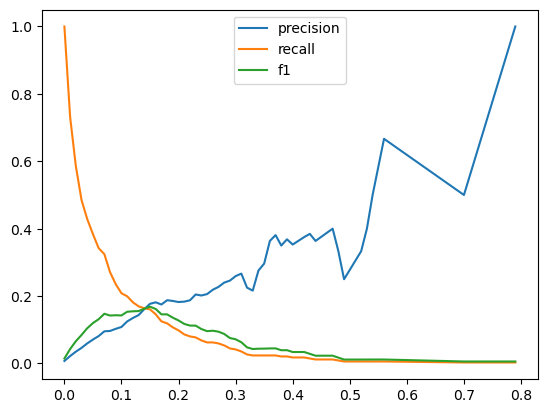

In [11]:
# plot f1 score over chosen threshold
probabilities = clf.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probabilities)
plt.plot(thresholds, precision[:-1], label="precision")
plt.plot(thresholds, recall[:-1], label="recall")
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1])
plt.plot(thresholds, f1, label="f1")
plt.legend()
plt.show()

In [12]:
probabilities

array([0., 0., 0., ..., 0., 0., 0.])

# Data statistics

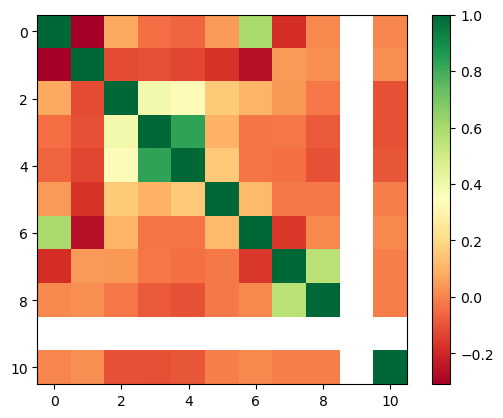

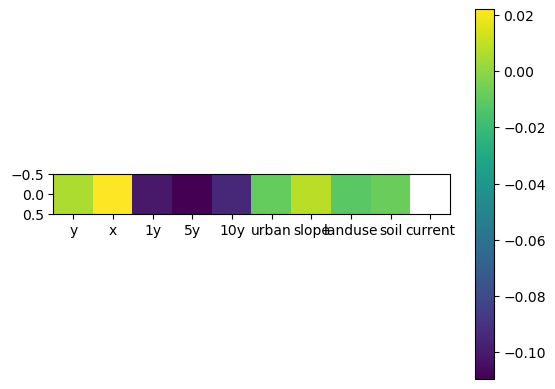

,y,x,1y,5y,10y,urban,slope,landuse,soil,current,target
y,1.000000,-0.310059,0.076204,-0.044332,-0.069425,0.043556,0.598293,-0.184609,0.010820,NaN,0.005583
x,-0.310059,1.000000,-0.115692,-0.105421,-0.127832,-0.167626,-0.261327,0.044074,0.022171,NaN,0.021955
1y,0.076204,-0.115692,1.000000,0.386963,0.334727,0.159035,0.101046,0.039843,-0.027902,NaN,-0.100573
5y,-0.044332,-0.105421,0.386963,1.000000,0.830658,0.096975,-0.029932,-0.026821,-0.087294,NaN,-0.109524
10y,-0.069425,-0.127832,0.334727,0.830658,1.000000,0.153615,-0.032407,-0.041692,-0.106216,NaN,-0.094246
urban,0.043556,-0.167626,0.159035,0.096975,0.153615,1.000000,0.118213,-0.023443,-0.023459,NaN,-0.009365
slope,0.598293,-0.261327,0.101046,-0.029932,-0.032407,0.118213,1.000000,-0.157276,0.008051,NaN,0.008453
landuse,-0.184609,0.044074,0.039843,-0.026821,-0.041692,-0.023443,-0.157276,1.000000,0.556785,NaN,-0.011802
soil,0.010820,0.022171,-0.027902,-0.087294,-0.106216,-0.023459,0.008051,0.556785,1.000000,NaN,-0.008152
current,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# cross correlation matrix
corr = train_features.corr()
plt.imshow(corr, cmap="RdYlGn")
plt.colorbar()
plt.show()
# plot last row
plt.imshow(corr.iloc[-1, :-1].values.reshape(1,10))
plt.xticks(np.arange(10), corr.columns[:-1])
plt.colorbar()
plt.show()
corr